# **Rating Prediction on 'Amazon Customer Review Data' with NLP**
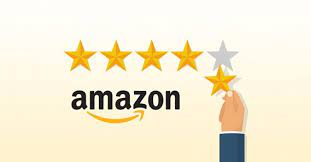






## **1. Importing Necessary Libraries**

In [ ]:

!pip install vaderSentiment
!pip install pyspellchecker

import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from wordcloud import WordCloud
from spellchecker import SpellChecker

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
# Suppress UndefinedMetricWarning
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# **2. Data Inspection**

Reading the dataset as pandas dataframe

In [ ]:
# read data from hosted link in github for easy access
df=pd.read_csv('https://raw.githubusercontent.com/umeshkhatiwada13/Datasets/main/amazon_reviews.csv')

In [ ]:
# get first 3 data from dataframe
df.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0


In [ ]:
# get last 3 data from dataframe
df.tail(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
4912,A2MR1NI0ENW2AD,B007WTAJTO,Z S Liske,"[0, 0]",Great card that is very fast and reliable. It ...,5.0,Fast and reliable memory card,1396224000,2014-03-31,252,0,0
4913,A37E6P3DSO9QJD,B007WTAJTO,Z Taylor,"[0, 0]",Good amount of space for the stuff I want to d...,5.0,Great little card,1379289600,2013-09-16,448,0,0
4914,A8KGFTFQ86IBR,B007WTAJTO,Zza,"[0, 0]",I've heard bad things about this 64gb Micro SD...,5.0,So far so good.,1388620800,2014-02-01,310,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      4915 non-null   object 
 1   asin            4915 non-null   object 
 2   reviewerName    4914 non-null   object 
 3   helpful         4915 non-null   object 
 4   reviewText      4914 non-null   object 
 5   overall         4915 non-null   float64
 6   summary         4915 non-null   object 
 7   unixReviewTime  4915 non-null   int64  
 8   reviewTime      4915 non-null   object 
 9   day_diff        4915 non-null   int64  
 10  helpful_yes     4915 non-null   int64  
 11  total_vote      4915 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 460.9+ KB


In [ ]:
# checkwhich columns has null value
df.isnull().sum()

reviewerID        0
asin              0
reviewerName      1
helpful           0
reviewText        1
overall           0
summary           0
unixReviewTime    0
reviewTime        0
day_diff          0
helpful_yes       0
total_vote        0
dtype: int64

In [ ]:
# dropping those two rows which have missing values
df.dropna(inplace=True)

In [ ]:
#ensuring there is no missing values now
df.isnull().sum()

reviewerID        0
asin              0
reviewerName      0
helpful           0
reviewText        0
overall           0
summary           0
unixReviewTime    0
reviewTime        0
day_diff          0
helpful_yes       0
total_vote        0
dtype: int64

In [ ]:
#shape of our dataset after treatment of the missing value rows
df.shape

(4913, 12)

In [ ]:
# get insight from numerical column of dataframe
df.describe().round(1)

,overall,unixReviewTime,day_diff,helpful_yes,total_vote
count,4913.0,4.913000e+03,4913.0,4913.0,4913.0
mean,4.6,1.379466e+09,437.3,1.3,1.5
std,1.0,1.580982e+07,209.4,41.6,44.1
min,1.0,1.339200e+09,1.0,0.0,0.0
25%,5.0,1.365898e+09,281.0,0.0,0.0
50%,5.0,1.381277e+09,431.0,0.0,0.0
75%,5.0,1.392163e+09,601.0,0.0,0.0
max,5.0,1.405296e+09,1064.0,1952.0,2020.0


In [ ]:
# check datatypes of all columns
df.dtypes

reviewerID         object
asin               object
reviewerName       object
helpful            object
reviewText         object
overall           float64
summary            object
unixReviewTime      int64
reviewTime         object
day_diff            int64
helpful_yes         int64
total_vote          int64
dtype: object

In [ ]:
# get length of reviewText column
len(df['reviewText'])

4913

In [ ]:
# unique values of review column in sorted order
print(sorted(df['overall'].unique()))

[1.0, 2.0, 3.0, 4.0, 5.0]


In [ ]:
# Stars and their value count
unique_values = df['overall'].unique()
for value in unique_values:
    count = df[df['overall'] == value].shape[0]
    print(f"{int(value)} Star: {count} review(s)")

5 Star: 3921 review(s)
4 Star: 526 review(s)
3 Star: 142 review(s)
1 Star: 244 review(s)
2 Star: 80 review(s)


# **3. Data Preprocessing**

In [ ]:
def preprocess_text(text):
    # convert to lowercase
    text = text.lower()

    text = clean_text(text)

    # Tokenization
    tokens = word_tokenize(text)

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Spell correction
    # spell = SpellChecker()
    # corrected_tokens = [spell.correction(token) for token in tokens]

    # lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Reconstruct the cleaned text
    cleaned_text = ' '.join(tokens)

    return cleaned_text

# function to handle text processing and return clean text
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[\w\.-]+@[\w\.-]+', '', text)  # Remove emails
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

In [ ]:
# apply preprocessing in data and add it as a new column
df['clean_review_text'] = df['reviewText'].apply(preprocess_text)

In [ ]:
df['clean_review_text'].head(5)

1    purchased device worked advertised never much ...
2    work expected sprung higher capacity think mad...
3    think worked greathad diff bran gb card went s...
4    bought retail packaging arrived legit orange e...
5    mini storage doesnt anything else supposed pur...
Name: clean_review_text, dtype: object

In [ ]:
# saving the original dataframe as df_old before dropping columns for further operations
df_old = df.copy()
# drop unnecessary columns from dataframe
df = df[['clean_review_text','overall']]
df.rename(columns={'overall':'rating'}, inplace=True)

<ipython-input-202-d2446996710d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'overall':'rating'}, inplace=True)


In [ ]:
df.head(3)

,clean_review_text,rating
1,purchased device worked advertised never much ...,5.0
2,work expected sprung higher capacity think mad...,4.0
3,think worked greathad diff bran gb card went s...,5.0


# **4. Visualization**

In [ ]:
# function to be used during section 4
# generates wordcloud for given text data
def generate_word_cloud(data, title, bg_color):
    if isinstance(data, list):
      data = ' '.join(data)

    wordcloud = WordCloud(width=800, height=400, random_state=42, max_words=100,
                          background_color=bg_color).generate(data)


    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

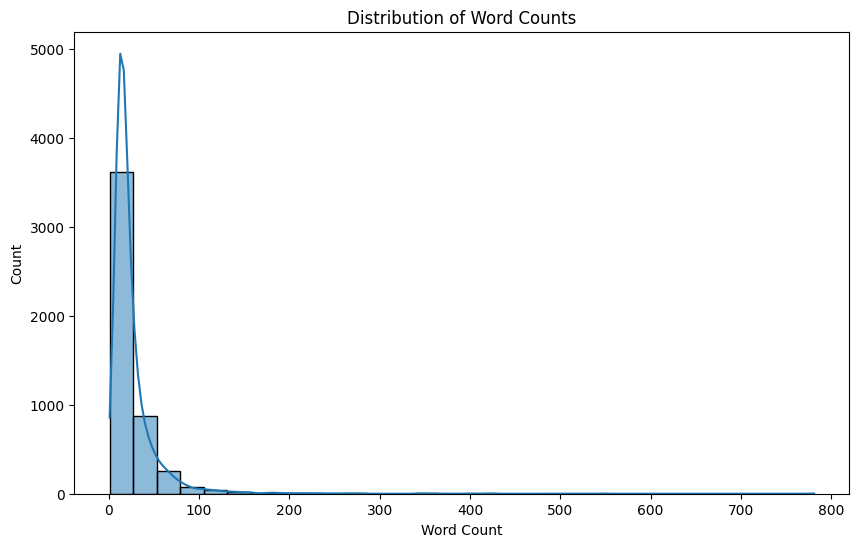

In [ ]:
# Calculate word counts for each document
word_counts = df['clean_review_text'].apply(lambda x: len(x.split()))

# Plot the histogram of word counts
plt.figure(figsize=(10, 6))
sns.histplot(word_counts, bins=30, kde=True)
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.show()


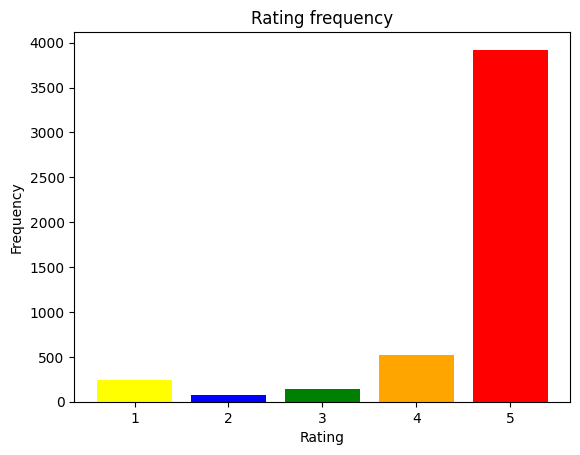

In [ ]:
# rating wise frequency count
ratings = df['rating'].value_counts()
colors = ['red', 'orange', 'yellow', 'green', 'blue']

plt.bar(ratings.index, ratings.values, color=colors)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating frequency')
plt.show()


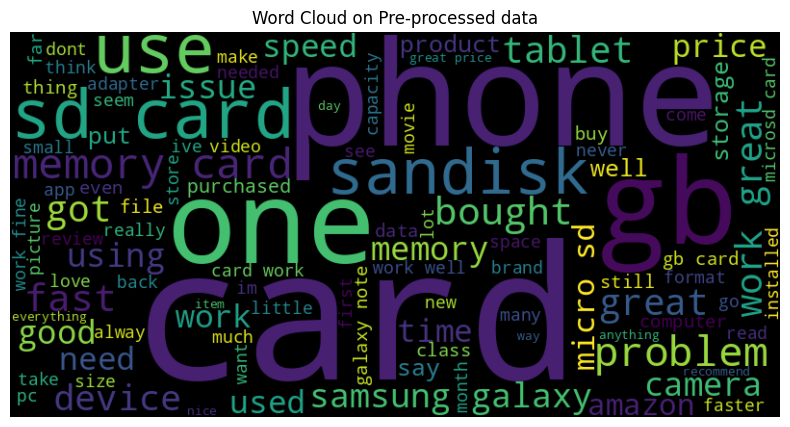

In [ ]:
text = " ".join(i for i in df.clean_review_text)
wordcloud = WordCloud().generate(text)
generate_word_cloud(text, 'Word Cloud on Pre-processed data' , 'black')

### **5. Feature Extraction**

In [ ]:
# function to be used during section 5

# function to calculate sentiment based on rating (1-5)
def get_vader_sentiment(review):

    analyzer = SentimentIntensityAnalyzer()
    sentiment_score = analyzer.polarity_scores(review)['compound']
    sentiment = ''
    if sentiment_score >= 0.05:
        sentiment = 'Positive'
    elif sentiment_score <= -0.05:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
    return sentiment_score, sentiment

In [ ]:
data = get_vader_sentiment("")
print(data)

(0.0, 'Neutral')


In [ ]:
# creating tfidf and storing it
# Calculate word frequencies for Bag of Words (CountVectorizer)
count_vectorizer = CountVectorizer()
X_count = count_vectorizer.fit_transform(df['clean_review_text'])
feature_names_count = count_vectorizer.get_feature_names_out()
count_word_freq = dict(zip(feature_names_count, X_count.sum(axis=0).tolist()[0]))

# Calculate word frequencies for TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_review_text'])
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
tfidf_word_freq = dict(zip(feature_names_tfidf, X_tfidf.sum(axis=0).tolist()[0]))

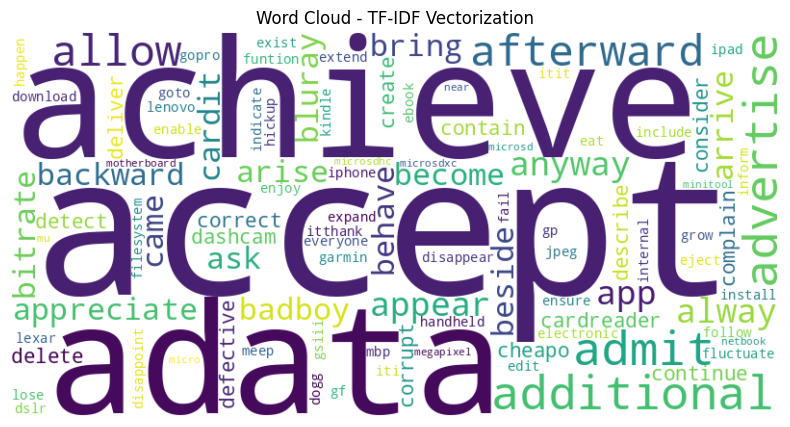

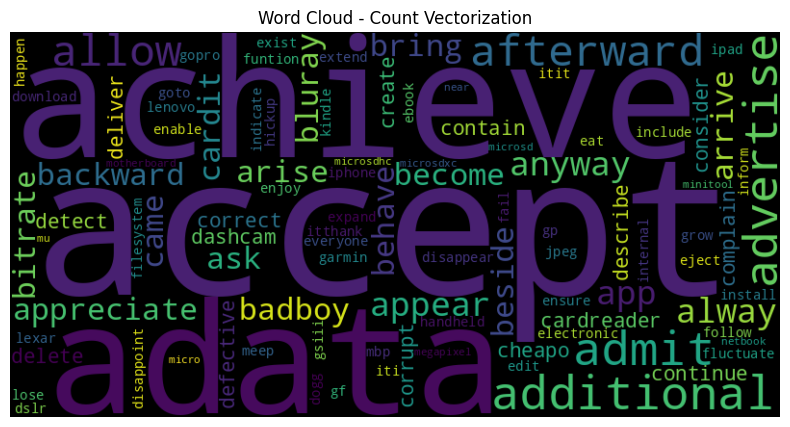

In [ ]:
# Generate and display word clouds for TF-IDF and Count Vectorization
generate_word_cloud(tfidf_vectorizer.get_feature_names_out().tolist(), 'Word Cloud - TF-IDF Vectorization', 'White')
generate_word_cloud(count_vectorizer.get_feature_names_out().tolist(), 'Word Cloud - Count Vectorization','Black')

In [ ]:
tfidf_dict = dict(zip(tfidf_vectorizer.get_feature_names_out(), X_tfidf.sum(axis=0).tolist()[0]))

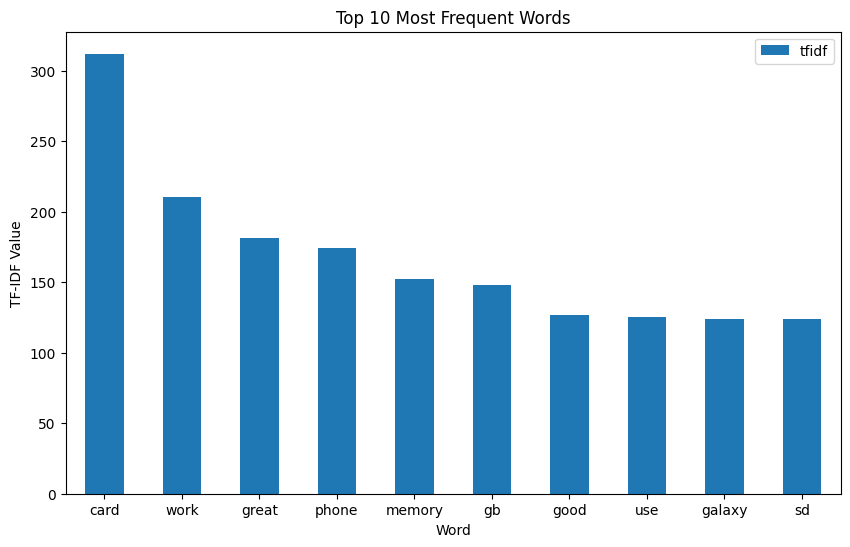

In [ ]:
# Convert TF-IDF dictionary to a DataFrame for easier manipulation
tfidf_df = pd.DataFrame.from_dict(tfidf_dict, orient='index', columns=['tfidf'])
tfidf_df = tfidf_df.sort_values(by='tfidf', ascending=False)

# Plot the top N most frequent words
top_n = 10
top_n_words = tfidf_df.head(top_n)
top_n_words.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Word')
plt.xticks(rotation=0)
plt.ylabel('TF-IDF Value')
plt.title('Top {} Most Frequent Words'.format(top_n))
plt.show()


In [ ]:
df['clean_review_text']

1       purchased device worked advertised never much ...
2       work expected sprung higher capacity think mad...
3       think worked greathad diff bran gb card went s...
4       bought retail packaging arrived legit orange e...
5       mini storage doesnt anything else supposed pur...
                              ...                        
4910    bought sandisk gb class use htc inspire month ...
4911    used extending capability samsung galaxy note ...
4912    great card fast reliable come optional adapter...
4913           good amount space stuff want fit gopro say
4914    ive heard bad thing gb micro sd card crapping ...
Name: clean_review_text, Length: 4913, dtype: object

In [ ]:
# implement VADER semtiment analyzer and append the data as vader_sentiment in existing df
sentiment_data = df['clean_review_text'].apply(get_vader_sentiment)
# Unpack the sentiment_data tuples into separate columns
df[['sentiment_score', 'vader_sentiment']] = sentiment_data.apply(pd.Series)

In [ ]:
df.head()

,clean_review_text,rating,sentiment_score,vader_sentiment
1,purchased device worked advertised never much ...,5.0,0.0000,Neutral
2,work expected sprung higher capacity think mad...,4.0,0.4019,Positive
3,think worked greathad diff bran gb card went s...,5.0,0.6486,Positive
4,bought retail packaging arrived legit orange e...,5.0,0.8591,Positive
5,mini storage doesnt anything else supposed pur...,5.0,0.0000,Neutral


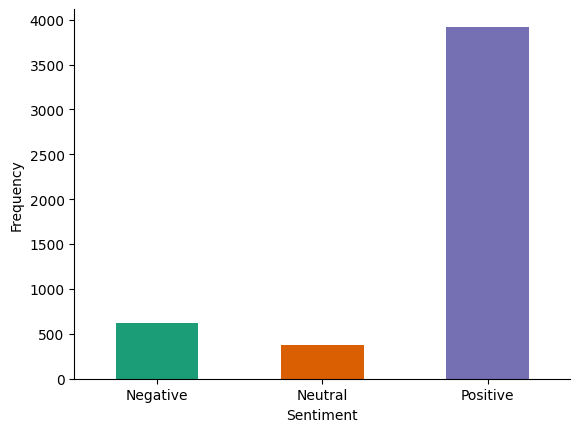

In [ ]:
# @title vader_sentiment

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('vader_sentiment').size().plot(kind='bar', color=sns.palettes.mpl_palette('Dark2'))
plt.xticks(rotation=0)
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.gca().spines[['top', 'right',]].set_visible(False)

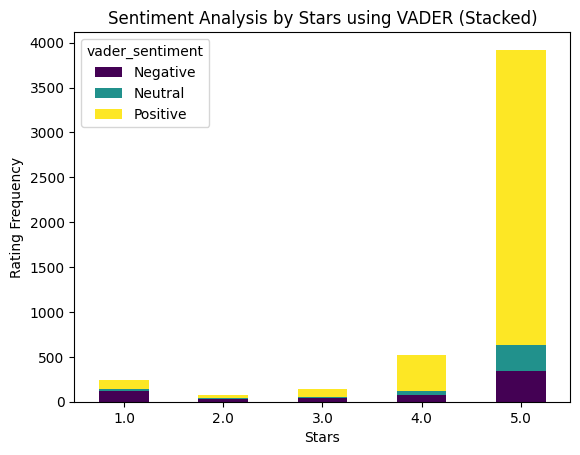

In [ ]:
# Rating wise sentimen bar graph
sentiment_stars_vader = df.groupby(['rating', 'vader_sentiment']).size().unstack(fill_value=0)
sentiment_stars_vader.plot(kind='bar', stacked=True, cmap='viridis')
plt.xlabel('Stars')
plt.ylabel('Rating Frequency')
plt.title('Sentiment Analysis by Stars using VADER (Stacked)')
plt.xticks(rotation=0)
plt.show()

# **6. Model Training**

In [ ]:
# function to be used in this stage
def evaluate_model(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    return accuracy, report, y_pred

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['clean_review_text'], df['rating'], test_size=0.2, random_state=42)


In [ ]:
# Vectorization
# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
# Get TF-IDF feature names and scores
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = X_tfidf.toarray().mean(axis=0)  #

# CountVectorizer
count_vectorizer = CountVectorizer(max_features=1000)
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)
# Get BoW feature names and frequencies
bow_feature_names = count_vectorizer.get_feature_names_out()
bow_frequencies = X_train_count.toarray().sum(axis=0)

# **Model 1 : Logistic Regression**

In [ ]:
def plot_confusion_matrix(y_test, y_pred, title):
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot heatmap
    # plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

    # Customize plot
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    # Add 1 to xticks and yticks  to show accurate star in matrix
    xtick_labels = [int(label.get_text()) + 1 for label in plt.gca().get_xticklabels()]
    ytick_labels = [int(label.get_text()) + 1 for label in plt.gca().get_yticklabels()]
    plt.xticks(ticks=plt.xticks()[0], labels=xtick_labels)
    plt.yticks(ticks=plt.yticks()[0], labels=ytick_labels)

In [ ]:
# Model building
# Logistic Regression with TF-IDF
tfidf_classifier = LogisticRegression(max_iter=1000)
tfidf_classifier.fit(X_train_tfidf, y_train)

# Logistic Regression with CountVectorizer
count_classifier = LogisticRegression(max_iter=1000)
count_classifier.fit(X_train_count, y_train)

# Evaluate TF-IDF classifier
tfidf_accuracy, tfidf_report,tfidf_ypred_classifier = evaluate_model(tfidf_classifier, X_test_tfidf, y_test)

# Evaluate CountVectorizer classifier
count_accuracy, count_report, count_ypred_classifier = evaluate_model(count_classifier, X_test_count, y_test)

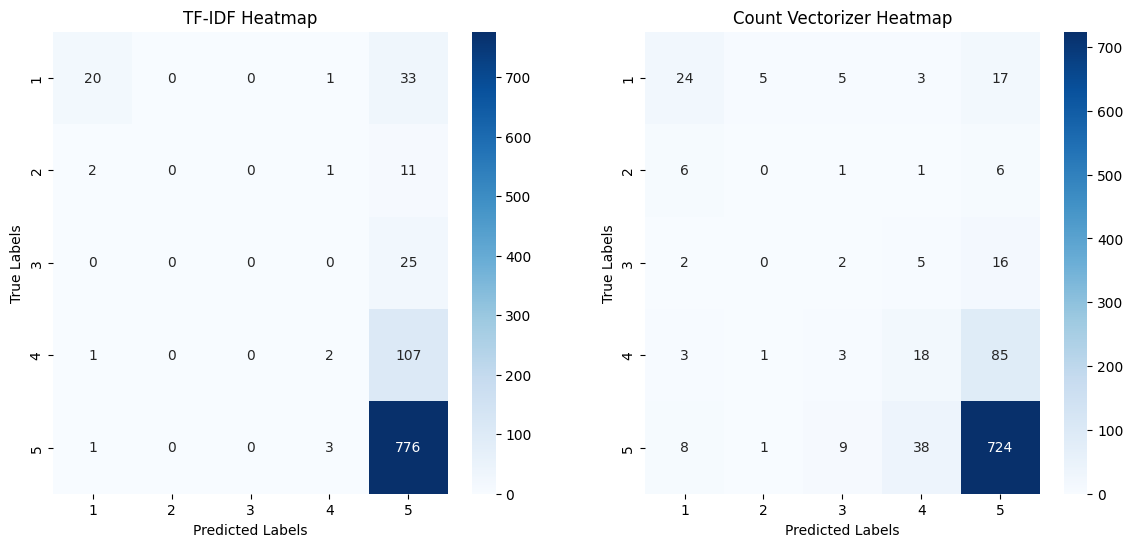

In [ ]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot confusion matrix for TF-IDF
plt.subplot(1, 2, 1)
plot_confusion_matrix(y_test, tfidf_ypred_classifier, "TF-IDF Heatmap")
# Plot confusion matrix for CountVectorizer
plt.subplot(1, 2, 2)
plot_confusion_matrix(y_test, count_ypred_classifier, "Count Vectorizer Heatmap")

plt.show()

In [ ]:
# Print results
print("TF-IDF Classifier Accuracy:", tfidf_accuracy)
print("TF-IDF Classifier Report:")
print(tfidf_report)

print("CountVectorizer Classifier Accuracy:", count_accuracy)
print("CountVectorizer Classifier Report:")
print(count_report)

TF-IDF Classifier Accuracy: 0.8118006103763988
TF-IDF Classifier Report:
              precision    recall  f1-score   support

         1.0       0.83      0.37      0.51        54
         2.0       0.00      0.00      0.00        14
         3.0       0.00      0.00      0.00        25
         4.0       0.29      0.02      0.03       110
         5.0       0.82      0.99      0.90       780

    accuracy                           0.81       983
   macro avg       0.39      0.28      0.29       983
weighted avg       0.72      0.81      0.74       983

CountVectorizer Classifier Accuracy: 0.7812817904374364
CountVectorizer Classifier Report:
              precision    recall  f1-score   support

         1.0       0.56      0.44      0.49        54
         2.0       0.00      0.00      0.00        14
         3.0       0.10      0.08      0.09        25
         4.0       0.28      0.16      0.21       110
         5.0       0.85      0.93      0.89       780

    accuracy         

# **Model 2: Random Forest Classifier**

In [ ]:
# Model building 2
# Random Forest with TF-IDF
rf_model_tf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_tf.fit(X_train_tfidf, y_train)

# Random Forest with count vectorizer
rf_model_count_vectorizer = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_count_vectorizer.fit(X_train_count, y_train)


# Evaluate TF-IDF classifier
tfidf_accuracy_rf, tfidf_report_rf,ypred_tfidf_rf = evaluate_model(rf_model_tf, X_test_tfidf, y_test)

# Evaluate CountVectorizer classifier
count_accuracy_rf, count_report_rf,ypred_count_rf = evaluate_model(rf_model_count_vectorizer, X_test_count, y_test)

# Print results
print("Random forest with Tf-IDF Accuracy:", tfidf_accuracy_rf)
print("Random Forest with TF-IDF Report:")
print(tfidf_report_rf)

print("Random forest with Tf-IDF Accuracy:", count_accuracy_rf)
print("Random Forest with CountVectorizer Report:")
print(count_report_rf)

Random forest with Tf-IDF Accuracy: 0.797558494404883
Random Forest with TF-IDF Report:
              precision    recall  f1-score   support

         1.0       0.55      0.11      0.18        54
         2.0       0.00      0.00      0.00        14
         3.0       0.00      0.00      0.00        25
         4.0       0.50      0.03      0.05       110
         5.0       0.80      0.99      0.89       780

    accuracy                           0.80       983
   macro avg       0.37      0.23      0.22       983
weighted avg       0.72      0.80      0.72       983

Random forest with Tf-IDF Accuracy: 0.797558494404883
Random Forest with CountVectorizer Report:
              precision    recall  f1-score   support

         1.0       0.42      0.09      0.15        54
         2.0       0.00      0.00      0.00        14
         3.0       0.00      0.00      0.00        25
         4.0       0.75      0.03      0.05       110
         5.0       0.80      0.99      0.89       780



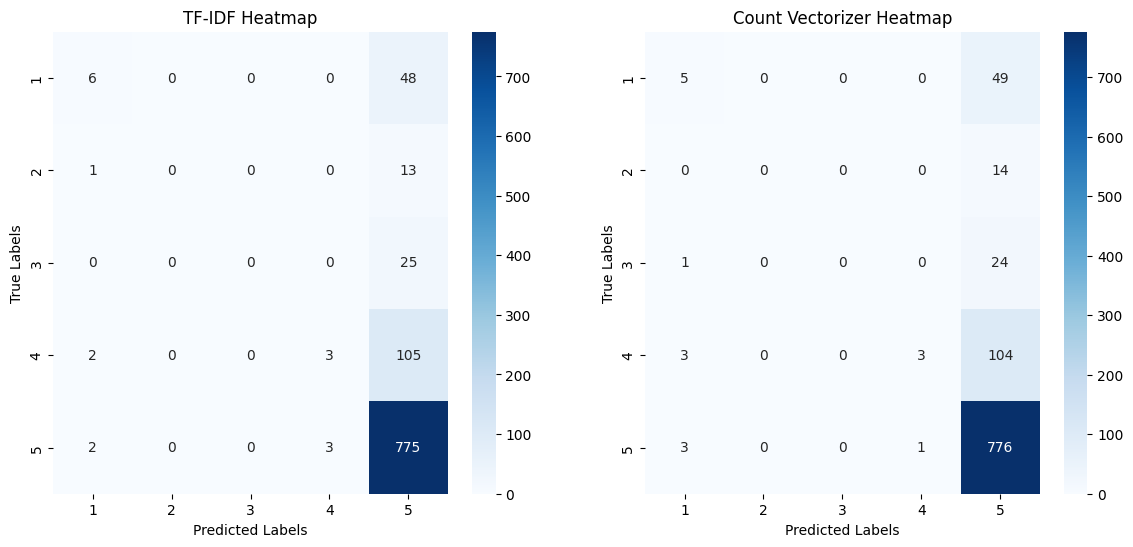

In [ ]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot confusion matrix for TF-IDF
plt.subplot(1, 2, 1)
plot_confusion_matrix(y_test, ypred_tfidf_rf, "TF-IDF Heatmap")
# Plot confusion matrix for CountVectorizer
plt.subplot(1, 2, 2)
plot_confusion_matrix(y_test, ypred_count_rf, "Count Vectorizer Heatmap")

plt.show()

In [ ]:
len(tfidf_feature_names)

1000

In [ ]:
#Appying second model for classification

In [ ]:
custom_review = "Amazing Product. Wow"

# Tokenize the custom review
custom_review_tokens = preprocess_text(custom_review)

# Transforming the custom review tokens into a count vectorized format
custom_review_vectorized = count_vectorizer.transform([custom_review_tokens])

# Predict the s of the custom review
predicted_rating = rf_model_count_vectorizer.predict(custom_review_vectorized)

print("Predicted rating star:", predicted_rating)

Predicted rating star: [5.]


The Model has predicted 5 stars for "Amazing Product. Wow", which seems accurate with our dataset

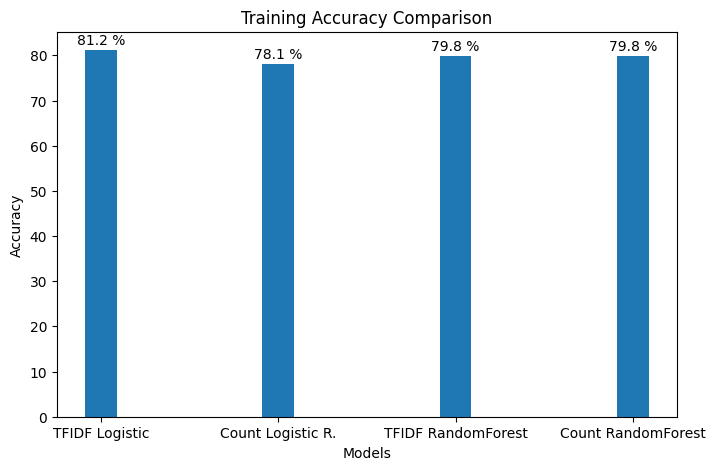

In [ ]:
train_scores=[tfidf_accuracy,count_accuracy,tfidf_accuracy_rf,count_accuracy_rf]

train_scores = [tf*100 for tf in train_scores]

models = ['TFIDF Logistic','Count Logistic R.','TFIDF RandomForest','Count RandomForest']

x = np.arange(len(models))

width = 0.18

fig, ax = plt.subplots(figsize=(8, 5))

rects1 = ax.bar(x, train_scores, width, label='Train Accuracy')
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.1f} %'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Training Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
plt.show()

# **Conclusion:**

Using TF-IDF Vectorizer for Logistic Regression:
F1-score (weighted average): 0.74<br> accuracy: 81.18 % <br>

Using CountVectorizer for Logistic Regression:
F1-score (weighted average): 0.76<br> accuracy: 78.13 %<br>

Using TF-IDF Vectorizer in Random Forest
F1-score (weighted average): 0.72<br> accuracy: 79.76 %<br>

Using CountVectorizer and Random Forest:
Accuracy: 79.76 % <br>
Weighted average F1 score: 0.72 <br>

<hr>

The optimal accuracy was obtained by Logistic Regression using TF-IDF Vectorizer (0.8118), which was followed by Random Forest using CountVectorizer (0.7976) and Random Forest using TF-IDF Vectorizer (79.76 %). The least accurate method was Logistic Regression using CountVectorizer (78.13 %).

**F1-score**: Logistic regression with TF-IDF Vectorizer (0.74) and Logistic regression with CountVectorizer (0.76) had the highest F1-scores, which take precision and recall into account. The F1-scores (0.72) of Random Forest models utilizing both vectorizers were marginally lower.

**Model Selection:** The best-performing model seems to be Logistic Regression with TF-IDF Vectorizer based only on accuracy. Nonetheless, the difference between the Random Forest and Logistic Regression models is not statistically significant when taking into account the overall performance indicators, such as the F1-score.

<hr>
**TF-IDF Classifier VS CountVectorizer Classifier**<br>
TF-IDF Classifier is more accurate (81.18 % as opposed to 78.13 %).
In comparison to the CountVectorizer Classifier, the TF-IDF Classifier performs better in terms of precision, recall, and F1-score for the majority of classes.
In general, the CountVectorizer Classifier performs worse than the TF-IDF Classifier.
<hr>

This dataset appears to yield slightly better results for Linear Regression with TF-IDF Vectorizer than for the other models. Nevertheless, when selecting the optimal model for deployment, it's critical to take into account additional elements including processing resources, scalability, and interpretability.
<hr>
The analysis conducted on the four models suggests that <b>Linear Regression with TF-IDF Vectorizer</b> is the most effective model. With <b>F1-score of 0.74 and the greatest accuracy of 81.18 %</b>, it demonstrated a fair balance between recall and precision.


# **Experimental steps for Better Accuracy**

# **Attempt 1 : Using one Numeric column(Date_diff) + Review**

We used just Review text for the model training to predict rating and the maximum accuracy obtained was 81.2 % using TFIDF vectorizer and Logistic Regression.
On the following steps, we are using one numerical column date_diff to check if we can obtain better accuracy

In [ ]:
# Split data into train and test sets
X = df_old[['clean_review_text','day_diff']]
y = df_old['overall']

X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorization
# TF-IDF vectorization
tfidf_vectorizer_v2 = TfidfVectorizer(max_features=1000)
X_train_tfidf_v2 = tfidf_vectorizer_v2.fit_transform(X_train_v2)
X_test_tfidf_v2 = tfidf_vectorizer_v2.transform(X_test_v2)

# Get TF-IDF feature names and scores
tfidf_feature_names_v2 = tfidf_vectorizer_v2.get_feature_names_out()
tfidf_scores_v2 = X_train_tfidf_v2.toarray().mean(axis=0)

print("Shape of X_train_tfidf_v2:", X_train_tfidf_v2.shape)
print("Shape of y_train_v2:", y_train_v2.shape)

Shape of X_train_tfidf_v2: (2, 2)
Shape of y_train_v2: (3930,)


In [ ]:


# Vectorization
# TF-IDF vectorization
tfidf_vectorizer_v2 = TfidfVectorizer(max_features=1000)
X_train_tfidf_v2 = tfidf_vectorizer_v2.fit_transform(X_train_v2)
X_test_tfidf_v2 = tfidf_vectorizer_v2.transform(X_test_v2)

# Get TF-IDF feature names and scores
tfidf_feature_names_v2 = tfidf_vectorizer_v2.get_feature_names_out()
tfidf_scores_v2 = X_train_tfidf_v2.toarray().mean(axis=0)


In [ ]:
# Define preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=1000), 'clean_review_text'),
        ('numeric', StandardScaler(), ['day_diff'])  # Pass numeric_column as a list to ensure it's treated as a 2D array
    ],
    remainder='passthrough'
)

# Split data into train and test sets
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing to training data
X_train_preprocessed = preprocessor.fit_transform(X_train_v2)

# Apply preprocessing to test data (only transform, no fitting)
X_test_preprocessed = preprocessor.transform(X_test_v2)



In [ ]:
# Logistic Regression with TF-IDF
tfidf_classifier_v2 = LogisticRegression(max_iter=1000)
tfidf_classifier_v2.fit(X_train_preprocessed, y_train_v2)

# Evaluate TF-IDF classifier
tfidf_accuracy, tfidf_report,tfidf_ypred_classifier = evaluate_model(tfidf_classifier_v2, X_test_preprocessed, y_test_v2)

In [ ]:
# CountVectorizer
count_vectorizer_v2 = CountVectorizer(max_features=1000)
X_train_count_v2 = count_vectorizer.fit_transform(X_train)
X_test_count_v2 = count_vectorizer.transform(X_test)

# Logistic Regression with CountVectorizer
count_classifier_v2 = LogisticRegression(max_iter=1000)
count_classifier_v2.fit(X_train_count_v2, y_train_v2)

# Evaluate CountVectorizer classifier
count_accuracy, count_report, count_ypred_classifier = evaluate_model(count_classifier_v2, X_test_count_v2, y_test_v2)

In [ ]:

# Print results
print("TF-IDF Classifier Accuracy:", tfidf_accuracy)
print("TF-IDF Classifier Report:")
print(tfidf_report)

print("CountVectorizer Classifier Accuracy:", count_accuracy)
print("CountVectorizer Classifier Report:")
print(count_report)

TF-IDF Classifier Accuracy: 0.8128179043743642
TF-IDF Classifier Report:
              precision    recall  f1-score   support

         1.0       0.82      0.43      0.56        54
         2.0       0.00      0.00      0.00        14
         3.0       0.00      0.00      0.00        25
         4.0       0.14      0.01      0.02       110
         5.0       0.82      0.99      0.90       780

    accuracy                           0.81       983
   macro avg       0.36      0.29      0.30       983
weighted avg       0.71      0.81      0.74       983

CountVectorizer Classifier Accuracy: 0.7812817904374364
CountVectorizer Classifier Report:
              precision    recall  f1-score   support

         1.0       0.56      0.44      0.49        54
         2.0       0.00      0.00      0.00        14
         3.0       0.10      0.08      0.09        25
         4.0       0.28      0.16      0.21       110
         5.0       0.85      0.93      0.89       780

    accuracy         

# **Accuracy Comparision (Reviews only vs Reviews and Date Diff (Numerical Column)**
Result using Reviews only:

    Accuracy of the TF-IDF Classifier: 81.28%

    Classifier F1-score (weighted average) for TF-IDF: 74%

    Accuracy of CountVectorizer Classifier: 78.13%

    F1-score (weighted average) for the CountVectorizer Classifier: 76%

Result using Reviews and Numerical column:

    Accuracy of the TF-IDF Classifier: 81.28%

    Classifier F1-score (weighted average) for TF-IDF: 74%

    Accuracy of CountVectorizer Classifier: 78.13%

    F1-score (weighted average) for the CountVectorizer Classifier: 76%

By comparing the outcomes, we can see that the accuracy and F1-score of both classifiers remained unchanged as a result of the numerical column's addition. The performance is still in line with the earlier findings, suggesting that the numerical column might not have a big effect on how well the model predicts the task at hand.


# **Attempt 2 : Using Vader Sentiment Score + Review Text**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Define text and numeric columns
text_column = 'clean_review_text'
numeric_column = 'sentiment_score'

# Split data into train and test sets
X_train_vader, X_test_vader, y_train_vader, y_test_vader = train_test_split(df[[text_column, numeric_column]], df['rating'], test_size=0.2, random_state=42)

#
pproc = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=1000), text_column),
        ('numeric', 'passthrough', [numeric_column])
    ],
    remainder='passthrough'
)

# Define the classifier
l_classifier = LogisticRegression(max_iter=1000)

# Create the pipeline
model_pipeline = Pipeline([
    ('preprocessor', pproc),
    ('classifier', l_classifier)
])

# Train the model
model_pipeline.fit(X_train_vader, y_train_vader)

# Evaluate CountVectorizer classifier
vader_accuracy, vader_report, vader_ypred_classifier = evaluate_model(model_pipeline, X_test_vader, y_test_vader)

In [ ]:
# Print results
print("Accuracy:", vader_accuracy)
print("Report:")
print(vader_report)

Accuracy: 0.814852492370295
Report:
              precision    recall  f1-score   support

         1.0       0.67      0.48      0.56        54
         2.0       0.00      0.00      0.00        14
         3.0       0.00      0.00      0.00        25
         4.0       0.29      0.02      0.03       110
         5.0       0.83      0.99      0.90       780

    accuracy                           0.81       983
   macro avg       0.36      0.30      0.30       983
weighted avg       0.72      0.81      0.75       983



# **Accuracy Comparision (Reviews only vs Reviews and Date Diff (Numerical Column)**

**Accuracy:** <br>
 The accuracy of the TF-IDF classifier that employs sentiment score in addition to review text is 81.49%, which is marginally higher than the 81.18% accuracy of the classifier that uses only review text.


**Precision, Recall, and F1-score:** <br>
 The classifier using sentiment score has a lower recall (48% vs. 37%) and a higher precision (67% vs. 83%) for the class with a rating of 1.0. As a result, the F1-scores are similar (56% vs. 51%).

Both classifiers exhibit comparable precision, recall, and F1-scores for the remaining classes (2.0, 3.0, and 4.0), which are typically poor because of insufficient support.
Due to the bulk of the data falling into this class, both classifiers for the class with a rating of 5.0 have high values for precision, recall, and F1-score.

**Weighted and Macro** <br>
For the classifier that incorporates emotion score, the macro and weighted averages for precision, recall, and F1-score are marginally higher, suggesting a marginally better overall performance.

# **Finding**
The Initial model performing the best was TF-IDF using **Logisitic Classifier with input review_text only whose accuracy was 81.18 %.** <br>
we were able to surpass the accuracy of model performing best initially by using a **numeric column (Vader sentiment score) together with review_text whose final accuracy was 81.49 % ie 0.31 % improvement.**

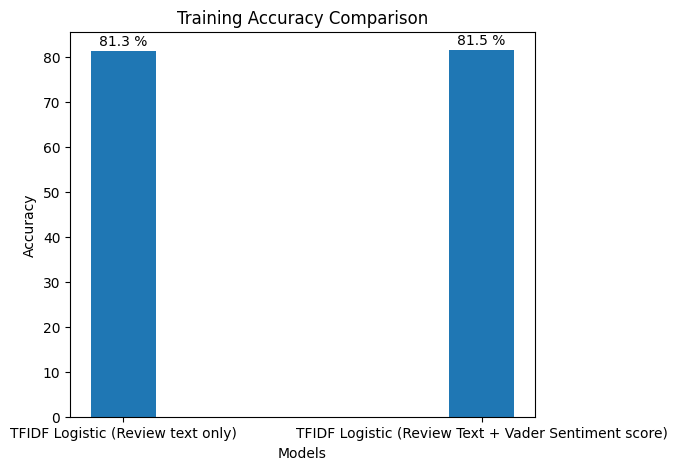

In [ ]:
# comparision graph between models with review_text column and
# model with review_text and vader sentiment score as input
train_scores=[tfidf_accuracy,vader_accuracy]

train_scores = [tf*100 for tf in train_scores]

models = ['TFIDF Logistic (Review text only)','TFIDF Logistic (Review Text + Vader Sentiment score)']

x = np.arange(len(models))

width = 0.18

fig, ax = plt.subplots(figsize=(6, 5))

rects1 = ax.bar(x, train_scores, width, label='Train Accuracy')
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.1f} %'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Training Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
plt.show()

In [ ]:
#saving our model as pickle file
save_rf_classifier = open("amazon_model_final.pkl","wb")
pickle.dump(rf_model_tf,save_rf_classifier)
save_rf_classifier.close()